In [1]:
---
title: Shazam en Python
description: Implementación de Shazam en una applicación de Python
show-code: False
params:
    recording:
        label: Canción a analizar
        input: file
        maxFileSize: 1MB
---

SyntaxError: invalid decimal literal (1874391363.py, line 9)

In [7]:
recording = "recording.wav"

In [8]:
# Imports
import numpy as np
import scipy
from scipy import signal
from scipy.io.wavfile import read
from scipy.fft import fft, fftfreq
import glob
from typing import List, Dict, Tuple
from tqdm import tqdm
import pickle
from pydub import AudioSegment
import matplotlib.pyplot as plt

In [9]:
# Function to create fingerprint from song
def create_fingerprint(audio, Fs):
  # Parameters
  window_length_seconds = 0.5
  window_length_samples = int(window_length_seconds * Fs)
  window_length_samples += window_length_samples % 2
  num_peaks = 15

  # Pad the song to divide evenly into windows
  amount_to_pad = window_length_samples - audio.size % window_length_samples
  song_input = np.pad(audio, (0, amount_to_pad))

  # Perform short time fourier transform
  frequencies, times, stft = signal.stft(
      audio, Fs, nperseg=window_length_samples, nfft=window_length_samples, return_onesided=True
  )

  fingerprint = []

  for time_idx, window in enumerate(stft.T):
    # Get real value from window period
    spectrum = abs(window)

    # Find peaks from spectrum
    peaks, props = signal.find_peaks(spectrum, prominence=0, distance=200)
    n_peaks = min(num_peaks, len(peaks))

    # Get largest peaks from spectrum
    largest_peaks = np.argpartition(props["prominences"], -n_peaks)[-n_peaks:]
    for peak in peaks[largest_peaks]:
        frequency = frequencies[peak]
        fingerprint.append([time_idx, frequency])
  return fingerprint

In [10]:
# Function to create hashes from fingerprint
def create_hashes(fingerprint, song_id=None):
  hashes = {}

  # Limit frequencies
  upper_bound = 23_000
  frequency_bits = 10

  # Hash over points in fingerprint
  for idx, (time, freq) in enumerate(fingerprint):
    # Iterate the next 100 pairs to produce hashes
    for other_time, other_freq in fingerprint[idx:idx+100]:
      diff = other_time - time
      # Ignore pair if difference between points is too small or too large
      if diff <= 1 or diff > 10:
        continue
      
      # Place frequencies into 1024 valued bins
      freq_binned = freq / upper_bound * (2 ** frequency_bits)
      other_freq_binned = other_freq / upper_bound * (2 ** frequency_bits)

      # Produce hash from binned frequencies and difference
      hash = int(freq_binned) | (int(other_freq_binned) << 10) | (int(diff) << 20)
      hashes[hash] = (time, song_id)
      
  return hashes

In [11]:
# Function to compare hash from recording to database
def score_hashes_against_database(hashes):
    matches_per_song = {}
    for hash, (sample_time, _) in hashes.items():
        if hash in database:
            matching_occurences = database[hash]
            for source_time, song_index in matching_occurences:
                if song_index not in matches_per_song:
                    matches_per_song[song_index] = []
                matches_per_song[song_index].append((hash, sample_time, source_time))
            

    # %%
    scores = {}
    for song_index, matches in matches_per_song.items():
        song_scores_by_offset = {}
        for hash, sample_time, source_time in matches:
            delta = source_time - sample_time
            if delta not in song_scores_by_offset:
                song_scores_by_offset[delta] = 0
            song_scores_by_offset[delta] += 1

        max = (0, 0)
        for offset, score in song_scores_by_offset.items():
            if score > max[1]:
                max = (offset, score)
        
        scores[song_index] = max

    # Sort the scores for the user
    scores = list(sorted(scores.items(), key=lambda x: x[1][1], reverse=True)) 
    
    return scores

In [12]:
# Print out top results
def find_song(file_name):
    # Load a short recording with some background noise
    Fs, audio_input = read(file_name)
    # Create fingerprint, hashes, and calculate score
    fingerprint = create_fingerprint(audio_input, Fs)
    hashes = create_hashes(fingerprint, None)
    scores = score_hashes_against_database(hashes)[:5]

    # Compare top results from database
    for song_id, score in scores:
        print(f"{song_name_index[song_id]}: Score of {score[1]} at {score[0]}")

In [13]:
# Create function to convert audio file to wav
def convert_to_wav(filename):
  """Takes an audio file of non .wav format and converts to .wav"""
  # Import audio file
  audio = AudioSegment.from_file(filename)
  
  # Export file as .wav
  audio.export("converted.wav", format="wav")

In [14]:
def mono_wav(file):
    mono_audio = AudioSegment.from_wav(file)
    mono_audio = mono_audio.set_channels(1)
    mono_audio.export("mono_audio.wav", format="wav")

In [15]:
# Load the database
database = pickle.load(open('database.pickle', 'rb'))
song_name_index = pickle.load(open("song_index.pickle", "rb"))

In [16]:
# Convert Audio
convert_to_wav(recording)
mono_wav("converted.wav")

Onda de la canción


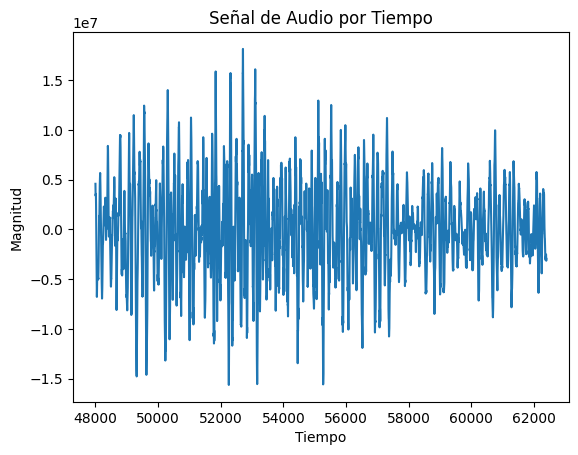

In [17]:
# Analyze song
Fs, song = read("mono_audio.wav")

print("Onda de la canción")
time_to_plot = np.arange(Fs * 1, Fs * 1.3, dtype=int);
plt.plot(time_to_plot, song[time_to_plot]);
plt.title("Señal de Audio por Tiempo")
plt.xlabel("Tiempo")
plt.ylabel("Magnitud");



Transformada de Fourier de la canción


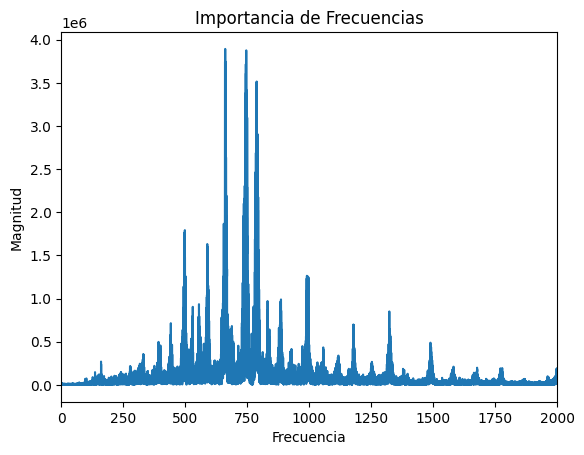

In [18]:
print("\n\nTransformada de Fourier de la canción")
N = len(song)
fft = scipy.fft.fft(song)
transform_y = 2.0 / N * np.abs(fft[0:N//2])
transform_x = scipy.fft.fftfreq(N, 1 / Fs)[:N//2]
plt.plot(transform_x, transform_y);
plt.title("Importancia de Frecuencias")
plt.xlabel("Frecuencia")
plt.ylabel("Magnitud")
plt.xlim(0, 2000);



Puntos altos


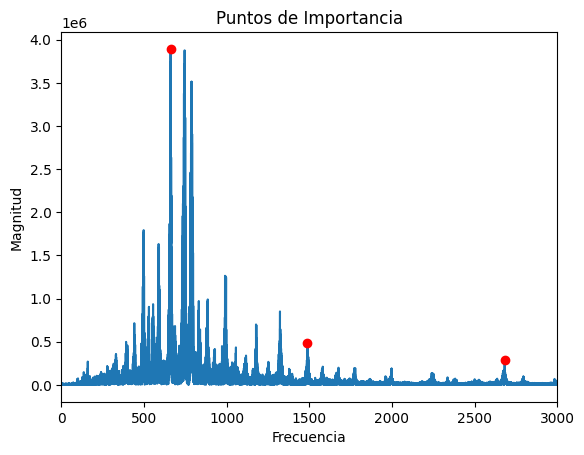

In [19]:
print("\n\nPuntos altos")
all_peaks, props = signal.find_peaks(transform_y)
peaks, props = signal.find_peaks(transform_y, prominence=0, distance=10000)
n_peaks = 15
# Get the n_peaks largest peaks from frequency chart
largest_peaks_indices = np.argpartition(props["prominences"], -n_peaks)[-n_peaks:]
largest_peaks = peaks[largest_peaks_indices]
plt.plot(transform_x, transform_y, label='Spectrum')
plt.scatter(
    transform_x[largest_peaks], transform_y[largest_peaks],
    color='r', zorder=10,
    label='Constrained Peaks'
    );
plt.title("Puntos de Importancia")
plt.xlabel("Frecuencia")
plt.ylabel("Magnitud")
plt.xlim(0, 3000);



Huella de la canción


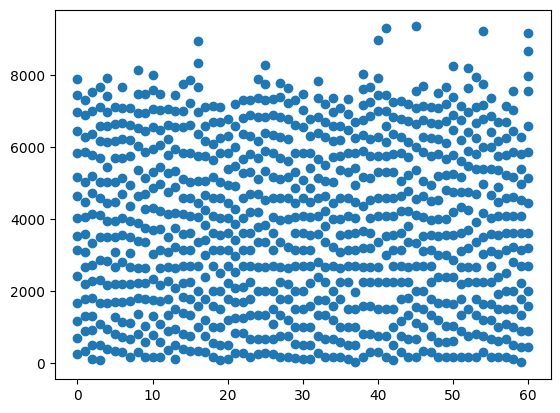

In [20]:
print("\n\nHuella de la canción")
finger = create_fingerprint(song, Fs)
plt.scatter(*zip(*finger));

In [21]:
print("\n\nComparación con base de datos")
find_song("mono_audio.wav")



Comparación con base de datos
/content/drive/MyDrive/Shazam/songs/18. Murray Perahia - Var. 17.wav: Score of 733 at 146
/content/drive/MyDrive/Shazam/songs/28. Murray Perahia - Var. 27, Canone alla nona.wav: Score of 366 at 321
/content/drive/MyDrive/Shazam/songs/09. Murray Perahia - Var. 8.wav: Score of 302 at 369
/content/drive/MyDrive/Shazam/songs/20. Murray Perahia - Var. 19.wav: Score of 295 at 292
/content/drive/MyDrive/Shazam/songs/11. Murray Perahia - Var. 10, Fughetta.wav: Score of 283 at 311
